# Part 2 : Analytical Acumen
Use your own judgement, interpretation and assumptions when responding to any of the open-ended questions. Specify any assumptions you make, where applicable.

**Prompt: Analyze draft position value and team success/deficiencies compared to expectation.**
- a. Create a method for valuing each draft slot in the NBA Draft (picks 1 through 60 in most drafts).
- b. Conditional on the expected value of the draft positions, which **NBA teams** have over or underperformed the most when drafting during this time span. Which **College Teams** have had the players outperform expectations the most after entering the NBA?
- c. Explain and present your findings with tables and visuals. What additional research areas would you focus on if given the opportunity to expand this study?


In [6]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization 
import matplotlib.pyplot as plt
from matplotlib import rcParams
from IPython import display
import seaborn as sns
import plotly.express as px 
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

# Formatting 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
display.set_matplotlib_formats("svg")
%matplotlib inline

In [7]:
dataset = pd.read_csv('draft_data.csv')

### 2.A 
Create a method for valuing each draft slot in the NBA Draft (picks 1 through 60 in most drafts).

When it comes to the value a player provides his team, we can see that LeBron is literally in his own tier. Since he's considered a generational talent, I'm going to consider him (and a few others) an outlier and remove him from the dataset. 

In [8]:
dataset.loc[dataset['player'] == "LeBron James"]

,id,year,rank,overall_pick,team,player,college,years_active,games,minutes_played,points,total_rebounds,assists,field_goal_percentage,3_point_percentage,free_throw_percentage,average_minutes_played,points_per_game,average_total_rebounds,average_assists,win_shares,win_shares_per_48_minutes,box_plus_minus,value_over_replacement,team_
785,786,2003,1,1,CLE,LeBron James,No College,19.0,1366.0,52139.0,37062.0,10210.0,10045.0,0.505,0.346,0.734,38.2,27.1,7.5,7.4,249.5,0.23,8.9,142.6,CLE


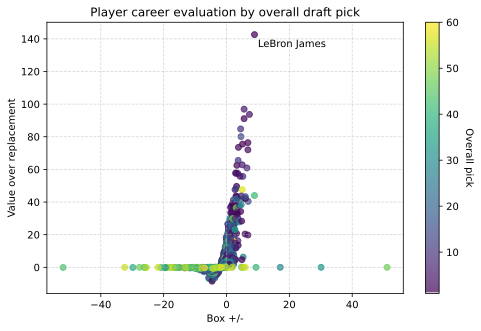

In [9]:
display.set_matplotlib_formats("svg")

fig, ax = plt.subplots(figsize=(8,5))

x = dataset["box_plus_minus"]
y = dataset["value_over_replacement"]
colors = dataset["overall_pick"]

scatter = ax.scatter(x, y,  c = colors, cmap='viridis', alpha=0.7)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Overall pick', rotation=270, labelpad=15)

# Set labels and title
ax.set_xlabel('Box +/-')
ax.set_ylabel('Value over replacement')
ax.set_title('Player career evaluation by overall draft pick')
ax.text(10, 135, "LeBron James", transform=ax.transData)

# Add grid lines
ax.grid(linestyle='--', alpha=0.5)

# Show the plot
plt.show()


In [10]:
dataset[['value_over_replacement', 'box_plus_minus', 'win_shares_per_48_minutes']].describe()

,value_over_replacement,box_plus_minus,win_shares_per_48_minutes
count,1669.000000,1668.000000,1668.000000
mean,4.403176,-2.311271,0.061691
std,11.461729,4.143403,0.094467
min,-8.500000,-52.000000,-1.264000
25%,-0.400000,-3.900000,0.030000
50%,0.000000,-2.000000,0.069000
75%,4.500000,-0.300000,0.104000
max,142.600000,51.100000,1.442000


I'm using z-score to remove outliers on both sides - the LeBrons of the world and the complete duds.

In [11]:
data = dataset.copy()
data['z_bpm'] = data.groupby('overall_pick')['box_plus_minus'].apply(lambda x: (x - x.mean())/x.std())
data['z_vor'] = data.groupby('overall_pick')['value_over_replacement'].apply(lambda x: (x - x.mean())/x.std())

outliers = data[(data['z_vor'] > 3) | (data['z_bpm'] > 3)]

# I'm removing the outliers by index from the dataset and creating a second dataframe, df, that will be used for analysis. 
df = dataset.loc[~dataset.index.isin(outliers.index)]

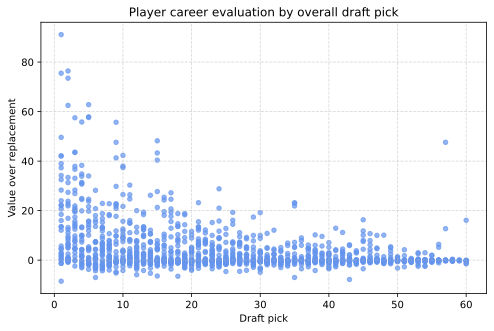

In [12]:
display.set_matplotlib_formats("svg")

fig, ax = plt.subplots(figsize=(8,5))

x = df["overall_pick"]
y = df["value_over_replacement"]

scatter = ax.scatter(x, y, s = 20, color = 'cornflowerblue', alpha=0.7)

ax.set_xlabel('Draft pick')
ax.set_ylabel('Value over replacement')
ax.set_title('Player career evaluation by overall draft pick')

ax.grid(linestyle='--', alpha=0.5)

plt.show()

To create a method for valuing each draft slot in the NBA Draft, I'm going with value_over_replacement. Since the graph appears to follow an exponential trend, I'm going to fit a line to the plot, and get a corresponding equation. This equation will only require overall_pick as a variable. The rest will be constants. The equation will allow us to enter the overall_pick and get the expected value_over_replacement.

After playing around with different equations, I went with the one below

In [13]:
df.dropna(subset=['value_over_replacement'], inplace = True)

In [14]:
from scipy.optimize import curve_fit

# Variables
x = df["overall_pick"]
y = df["value_over_replacement"]

# Curve fitting
def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

params, _ = curve_fit(exponential_func, x, y)

a, b, c = params
equation = f"{a:.2f} * exp(-{b:.2f} * x) + {c:.2f}"
print("Fitted Equation:", equation)

# Determine quality of the fit
squared_diffs = np.square(y - exponential_func(x, a, b, c))
squared_diffs_from_mean = np.square(y - np.mean(y))
r_squared = 1 - np.sum(squared_diffs) / np.sum(squared_diffs_from_mean)
print("R-squared:", r_squared.round(2))

Fitted Equation: 20.75 * exp(-0.15 * x) + 0.92
R-squared: 0.22


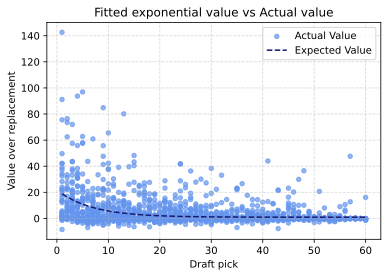

In [15]:
display.set_matplotlib_formats("svg")

fig, ax = plt.subplots(figsize=(6,4))

x = dataset["overall_pick"]
y = dataset["value_over_replacement"]

x_line = np.linspace(1, np.max(x), 61)
y_line = exponential_func(x_line, a, b, c)

plt.scatter(x, y,  s = 20, color = 'cornflowerblue', alpha=0.7, label='Actual Value')
plt.plot(x_line, y_line, '--', color= "midnightblue",  label='Expected Value')

ax.set_xlabel('Draft pick')
ax.set_ylabel('Value over replacement')
ax.set_title('Fitted exponential value vs Actual value')
ax.grid(linestyle='--', alpha=0.5)

plt.legend(loc = 'upper right')
plt.show()


Now with a formula, we can add a column to our dataset to value each draft pick,

In [16]:
dataset.dropna(subset=['value_over_replacement'], inplace = True) # to avoid NaN
dataset['exp_value'] = exponential_func(dataset['overall_pick'], a, b, c)
dataset['v_diff'] = dataset['value_over_replacement'] - dataset['exp_value']

### 2.B 
Conditional on the expected value of the draft positions, 
- which **NBA teams** have over or underperformed the most when drafting during this time span. 
- which **College Teams** have had the players outperform expectations the most after entering the NBA?

**NBA teams**

In [17]:
nba_overall_vorp= dataset.groupby('team_')['v_diff'].mean().reset_index()
top_overall_team = nba_overall_vorp.sort_values(by='v_diff', ascending= False)
nba_top= top_overall_team.head(5)
nba_bottom= top_overall_team.tail(5)
nba_df = pd.concat([nba_top, nba_bottom])

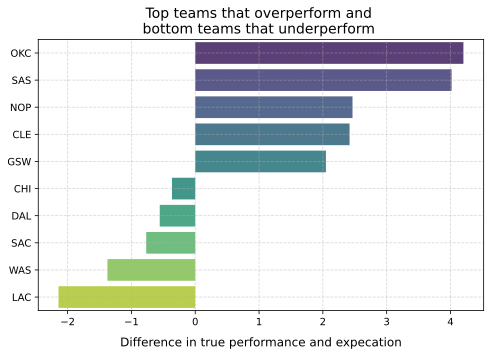

In [18]:
fig, ax= plt.subplots(figsize=(8, 5))

sns.barplot(x="v_diff", 
    y="team_", 
    data=nba_df, 
    palette = 'viridis', 
    alpha = 0.9,
    ci=None, 
    order=nba_df['team_'])

#ax.spines[['top','right']].set_visible(False)
ax.set_xlabel('Difference in true performance and expecation', fontsize = 12, labelpad=10)
ax.set_ylabel('', labelpad=10)
ax.set_title('Top teams that overperform and \nbottom teams that underperform ', fontsize=14)
ax.grid(linestyle='--', alpha=0.5)

plt.show()

image_format = 'png'
image_name = 'nba_teams.png'
fig.savefig(image_name, format=image_format)


**Colleges** 

I decided to get rid of colleges with 3 or less players to make it to the NBA. It didn't seem fair to compare Trinity Valley CC and Kentucky.

In [19]:
schools = dataset.groupby(['college']).size().reset_index().rename(columns={0:'count'})
schools.sort_values(['count'], ascending = False).head()

to_drop = schools.loc[schools['count'] < 4]
to_drop = to_drop['college'].to_list()

colleges = dataset.loc[~dataset['college'].isin(to_drop)]

In [20]:
college_overall_vorp= colleges.groupby('college')['v_diff'].mean().reset_index()
top_overall_college = college_overall_vorp.sort_values(by='v_diff', ascending= False)
college_top = top_overall_college.head(5)
college_bottom = top_overall_college.tail(5)
colleges_df = pd.concat([college_top, college_bottom])

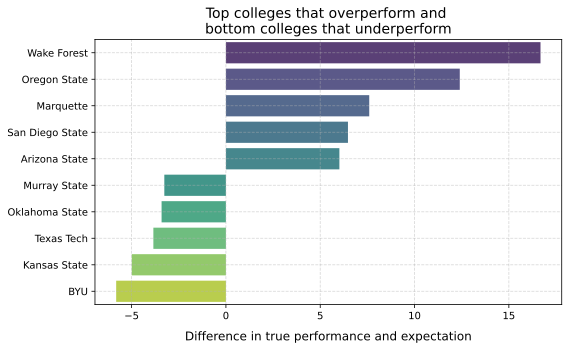

In [21]:
fig, ax= plt.subplots(figsize=(8, 5))

sns.barplot(x="v_diff", 
    y="college", 
    data= colleges_df, 
    palette = 'viridis',
    alpha = 0.9,
    ci=None, 
    order=colleges_df['college'])

#ax.spines[['top','right']].set_visible(False)
ax.set_xlabel('Difference in true performance and expectation', fontsize = 12, labelpad=10)
ax.set_ylabel('', labelpad=10)
ax.set_title('Top colleges that overperform and \nbottom colleges that underperform', fontsize=14)
ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

image_format = 'png'
image_name = 'college_teams.png'
fig.savefig(image_name, format=image_format)